In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class glob_variables:
    bed_count = 0
    mean_inter_arrival_time = .2
    mean_length_of_stay = 21
    sim_duration = 548
    check_times = []
    check_beds = []
    check_intervals = 7
    delay = 30

In [3]:
def patient(env,i,p_length_of_stay):
    # add 1 to bed count while the patient is in the hospital
    glob_variables.bed_count+=1
    # trigger event when the patient is better
    yield env.timeout(p_length_of_stay)
    # reduce bed count after patient leaves
    glob_variables.bed_count-=1
    
def new_patient(env,inter_arrival_time,length_of_stay):
    i = 0
    while True:
        i+=1
        # patient length of stay is drawn from exponential distribution
        p_length_of_stay = random.expovariate(1/length_of_stay)
        # create a new patient
        p = patient(env,i,p_length_of_stay)
        # start patient process
        env.process(p)
        # define next patient based on inter arrival time
        next_p = random.expovariate(1/inter_arrival_time)
        # trigger event when new patient comes
        yield env.timeout(next_p)

In [4]:
def check(env, delay):
    yield env.timeout(delay)
    while True:
        glob_variables.check_times.append(env.now)
        glob_variables.check_beds.append(glob_variables.bed_count)
        yield env.timeout(glob_variables.check_intervals)

In [5]:
env = simpy.Environment()
env.process(new_patient(env,glob_variables.mean_inter_arrival_time,glob_variables.mean_length_of_stay))
env.process(check(env,120))

<Process(check) object at 0x115b3d450>

In [6]:
env.run(until=glob_variables.sim_duration)

In [7]:
Hospital_Ut = pd.DataFrame()
Hospital_Ut["Days Since Outbreak"] = glob_variables.check_times
Hospital_Ut["Bed Count"] = glob_variables.check_beds

In [8]:
def plot_graph():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(Hospital_Ut['Days Since Outbreak'],Hospital_Ut['Bed Count'])
    ax.set_xlabel('Days Since Outbreak')
    ax.set_ylabel('Bed Count')
    ax.axvspan(0,glob_variables.delay,color = "red",alpha=0.1)
    ax.text(glob_variables.delay/3,max(glob_variables.check_beds)*.55,"Delay before hospitals start tracking beds",fontstyle = "italic", rotation = "vertical")
    ax.axvline(glob_variables.delay,color="red",alpha = 0.4, dashes = [5,5,5,5])
    plt.xlim(0,glob_variables.sim_duration)
    plt.title("Hospital Bed Usage Since Outbreak",fontweight = "bold")

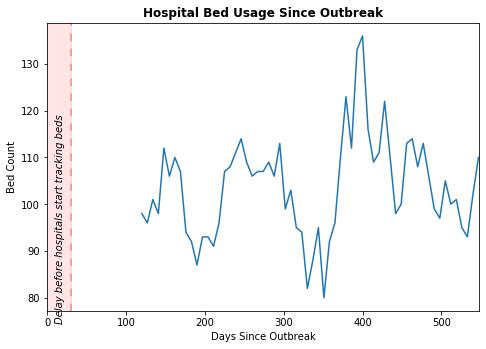

In [9]:
plot_graph()